#### 41/43. Good job

In [ ]:
# Python Version 3.11.4, conda version 23.1.0

In [69]:
import pandas as pd # v 1.4.4
import numpy as np # v 1.21.5
import pmdarima as pm # v 2.0.3
import statsmodels.api as sm # v 0.13.2
import matplotlib.pyplot as plt # 3.5.2
import pandas_profiling as pp # v 3.6.6
import warnings as ww
import statsmodels.tsa.stattools as stattools  # v 0.13.2

from statsmodels.tsa.stattools import adfuller # v 0.13.2
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # v 0.13.2
from statsmodels.tsa.arima_model import ARIMA # v 0.13.2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [70]:
print(pd.__version__)

1.4.4


In [71]:
ww.filterwarnings("ignore")
%matplotlib inline

In [72]:
df = pd.read_csv("/Users/maiavachon/Documents/GitHub/DATA-300-Statistical-Machine-Learning-Fall-2023-/Data/Electric_Production.csv")

#1. ARIMA, exponential smoothing, moving averages
#2. weather forecasting, marketing forecasting, supply/demand, etc.
#3. a time series data set uses one variable that is recorded through time while a panel dataset utilizes more than one variable
#4. in time series tasks, we cannot use random sampling because the dates must be in order to understand patterns throughout time whereas for regression and classification problems, the order in which the data appears does not matter
#5a. stationarity refers to the state of time series data that is not influenced by seasonality, trends, etc to better understand any patterns that could be there. it is important for the data to be stationary before modeling!
#5b. differencing refers to the process of making a non-stationary time series stationary by subtracting the previous value by the current value.
#5c. a white noise series is a time series that is IID with a mean of 0 and a constant variance. it is a baseline time series model because there is no pattern between the points
#5d. a random walk series is a time series where the current observation equals the previous observation with a random step up or down. these values are unpredictable and wouldn't be appropriate for modeling
#6a. this equation would be an example of ARMA in which "c" designates the baseline coefficient, the epsilon standing for the error term at the current period, the o with the slash meaning the coefficient for the specified (i) lag, the 0 with the slash meaning the same for a past lag (how much can be used today?), and lastly the epsilon with the t meaning the error term for a past period
#6b. no, we cannot tell whether the time series has been differenced because the data should have been plotted and differenced (if applicable) before building this model
#6c. AR(3) and MA(4)
#6d. you would determine the AR order by building a PACF plot to show the correlation of different lags and including significant lags in the model. to determine the MA order, you would plot the ACF (autocorrelation function) and read it in the same way as the PACF plot.

In [73]:
#1. the only thing that this profile report alerts is that there is high cardinality in the variables, which means that they are all different!
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [74]:
#this tells python that these values are dates
df["DATE"] = pd.to_datetime(df["DATE"]) 

#sort the data by date!
df = df.sort_values("DATE") 


In [75]:
#2

#define a function that performes the ADF test and prints the test statistic, p-value, lags used, and number of observations
def adfuller_test(timeseries):
    result=adfuller(timeseries)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label +': '+ str(value))

    #depending on the result, there is strong/weak evidence for H1
    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
    else:
        print("There is weak evidence against the null hypothesis, indicating it is non-stationary")
        
#print the ADF test results 
for k in df.columns:
    print(k), adfuller_test(df[k])
    print()    

#KPSS test for stationarity
for k in df.columns:
    print(k)
    print()
    print(stattools.kpss(df[k], regression='ct'))
    print()
    
#according to the p value, 0.01, the KPSS test indicates that the IPG2211A2N variable is not stationary at 0.05

DATE
ADF Test Statistic: -0.14017905755795057
p-value: 0.9452865588327853
#Lags Used: 12
Number of Observations: 384
There is weak evidence against the null hypothesis, indicating it is non-stationary

IPG2211A2N
ADF Test Statistic: -2.2569903500472366
p-value: 0.18621469116587053
#Lags Used: 15
Number of Observations: 381
There is weak evidence against the null hypothesis, indicating it is non-stationary

DATE

(0.017153236083679475, 0.1, 7, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

IPG2211A2N

(0.5051030832418592, 0.01, 16, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})



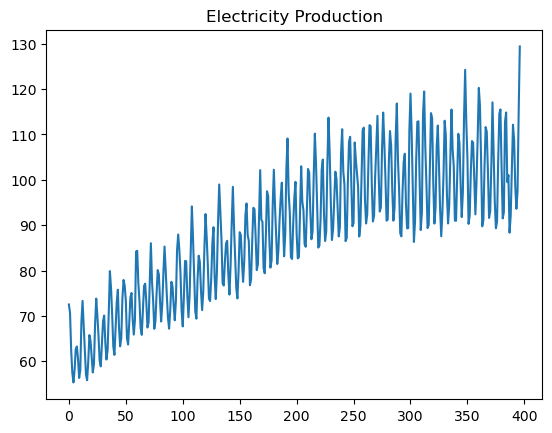

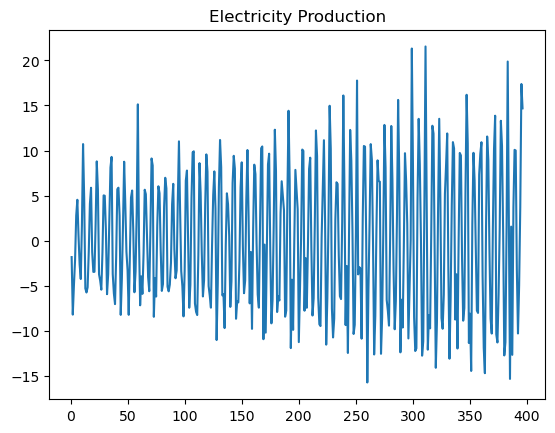

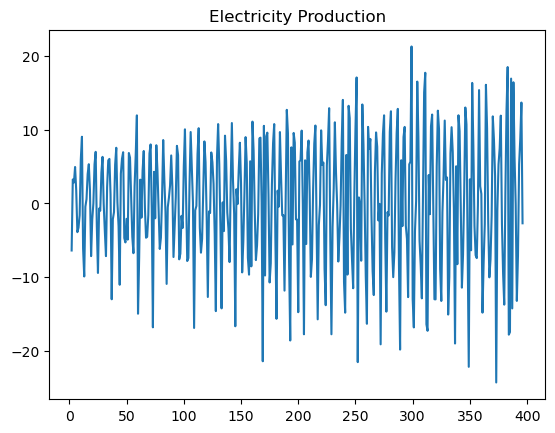

In [76]:
#3. 

#first plot, no differencing
df["IPG2211A2N"].plot()
plt.title("Electricity Production")

plt.show()

#second plot, differencing once
df["IPG2211A2N"].diff().plot()
plt.title("Electricity Production")

plt.show()

#third plot, differencing twice
df["IPG2211A2N"].diff().diff().plot()
plt.title("Electricity Production")

plt.show()

#the progression of these three graphs show the power of differencing as the spread of the graph data moves closer around 0

DATE

IPG2211A2N



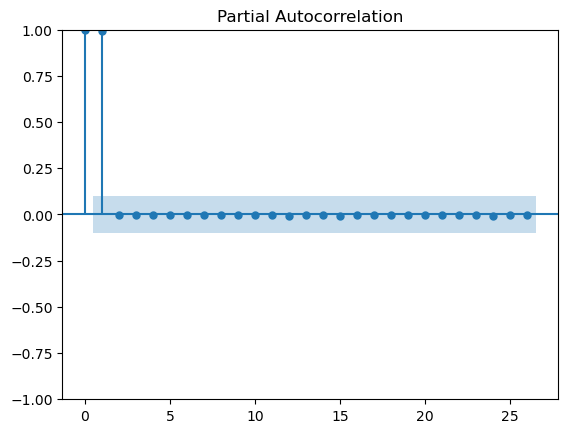

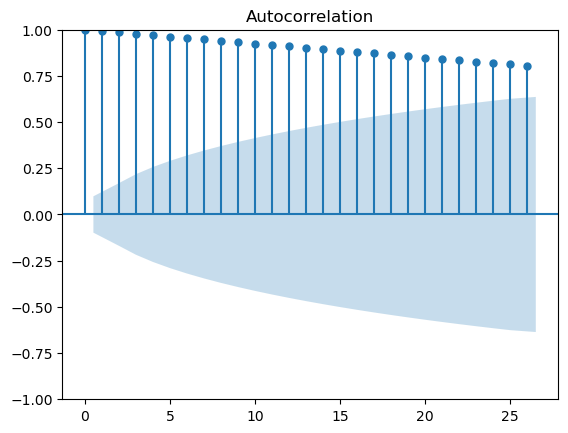

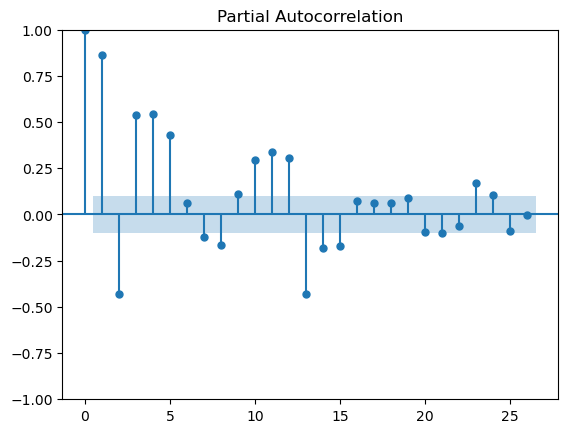

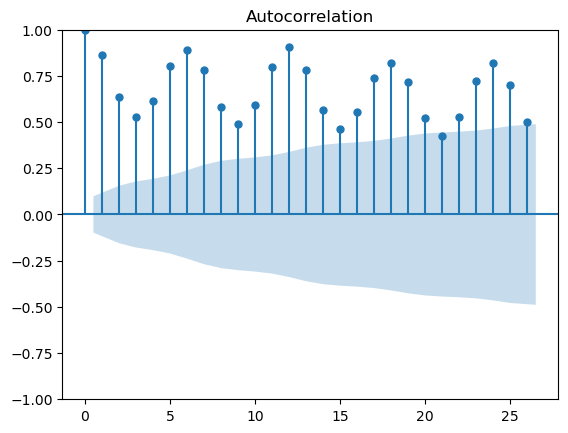

In [77]:
#4

#plot the PACF and ACF plots to determine the AR and MA orders
for i in df.columns:
    print(i)
    plot_pacf(df[i])
    plot_acf(df[i])
    print()

#according to the PACF and ACF tests, the DATE variable -> AR(1) and MA(>25) but because this is the date variable, this is okay.
#according to the PACF and ACF tests, the IPG2211A2N variable -> AR(5) and MA(20)

In [78]:
#5. ARIMA(5,0,20) # if your data is non statationary, you need to difference it at least once. so (5,1,20) (-2)

In [79]:
#6.

model = sm.tsa.arima.ARIMA(df['IPG2211A2N'].head(int(0.7*len(df))), order=(5, 0, 20)) # The ARIMA order is not correct. 
results = model.fit()

#we fit the model to the ARIMA order (5,0,20) by splitting 70% of the data into the training set

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             IPG2211A2N   No. Observations:                  277
Model:                ARIMA(5, 0, 20)   Log Likelihood                -663.619
Date:                Mon, 02 Oct 2023   AIC                           1381.237
Time:                        14:32:18   BIC                           1479.086
Sample:                             0   HQIC                          1420.498
                                - 277                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.1324      7.649     10.869      0.000      68.141      98.124
ar.L1          0.3102      0.074      4.214      0.000       0.166       0.455
ar.L2          0.4797      0.089      5.377      0.000       0.305       0.654
ar.L3         -0.6000      0.064     -9.380      0.000      -0.725      -0.475
ar.L4         -0.0843      0.077     -1.099      0.272      -0.235       0.066
ar.L5          0.8696      0.069     12.661      0.000       0.735       1.004
ma.L1          0.4412      0.151      2.925      0.003       0.146       0.737
ma.L2         -0.3261      0.167     -1.949      0.051      -0.654       0.002
ma.L3          0.4733      0.235      2.014      0.044       0.013       0.934
ma.L4          0.4939      0.194      2.542      0.011       0.113       0.875
ma.L5         -0.7006      0.218     -3.213      0.001      -1.128      -0.273
ma.L6         -0.4305      0.262     -1.645      0.100      -0.943       0.082
ma.L7          0.0302      0.207      0.146      0.884      -0.375       0.436
ma.L8         -0.1854      0.184     -1.007      0.314      -0.546       0.175
ma.L9         -0.1828      0.280     -0.653      0.514      -0.732       0.366
ma.L10         0.3073      0.177      1.735      0.083      -0.040       0.654
ma.L11         0.3331      0.245      1.360      0.174      -0.147       0.813
ma.L12         0.5914      0.151      3.912      0.000       0.295       0.888
ma.L13         0.2400      0.201      1.194      0.232      -0.154       0.634
ma.L14        -0.2415      0.167     -1.446      0.148      -0.569       0.086
ma.L15         0.3102      0.171      1.812      0.070      -0.025       0.646
ma.L16         0.2033      0.144      1.414      0.157      -0.079       0.485
ma.L17        -0.4418      0.142     -3.104      0.002      -0.721      -0.163
ma.L18        -0.1961      0.109     -1.801      0.072      -0.409       0.017
ma.L19        -0.0945      0.089     -1.061      0.289      -0.269       0.080
ma.L20        -0.0293      0.088     -0.334      0.738      -0.201       0.143
sigma2         6.4574      1.726      3.742      0.000       3.075       9.840
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 8.65
Prob(Q):                              0.34   Prob(JB):                         0.01
Heteroskedasticity (H):               1.81   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

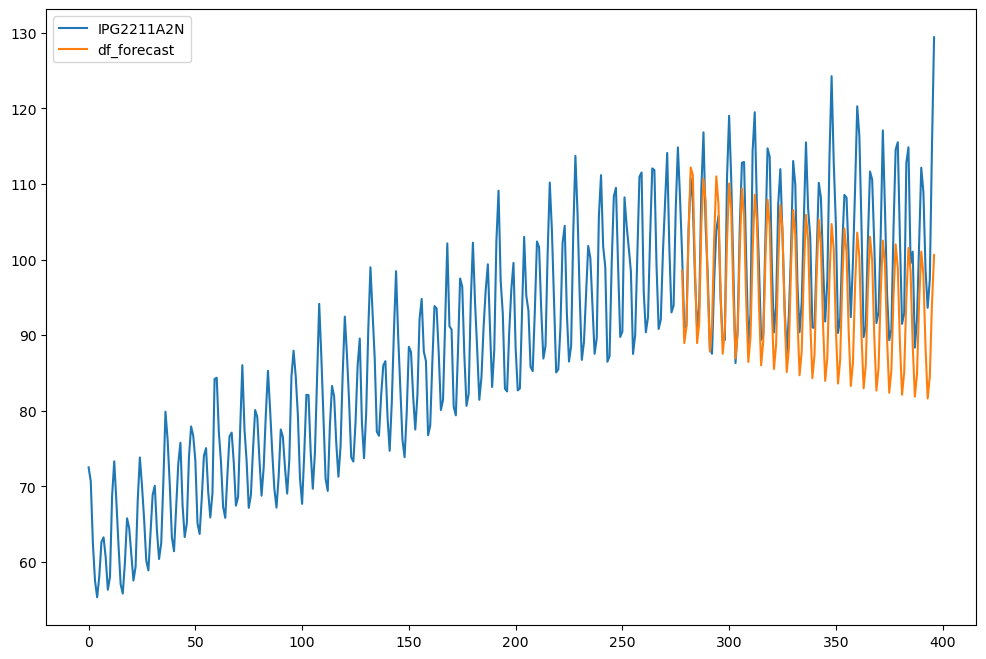

In [80]:
#7.

df['df_forecast']=results.predict(start = int(0.7*len(df))+1, end=len(df), dynamic=True)
#to forecast the data onto the test set, we must capture 30% of the data and add a new column to the dataset called df_forecast

df[['IPG2211A2N','df_forecast']].plot(figsize=(12,8))
#plotting the forecast with the y variable, but this doesn't look quite right...

In [81]:
#8.

print(mean_squared_error(df['df_forecast'].tail(int(0.3*len(df))),df['IPG2211A2N'].tail(int(0.3*len(df)))))
#calculate MSE for the test set (30% of the data)

print(mean_absolute_error(df['df_forecast'].tail(int(0.3*len(df))),df['IPG2211A2N'].tail(int(0.3*len(df)))))
#calculate MAE for the test set (30% of the data)

75.61544664776282
7.112165764860672


In [82]:
#9.

#overall, i do not think that this model is good. however, if we had proceeded to create the model with differenced data (stationary), i think that it would have turned out better. the high error values indicate that the model's predictions have relatively large errors when squared but that the MAE (7.11) is smaller than the MSE (75.615).